In [36]:
# This analysis: % K-mer containment comparison

Sketch of the problem:
* To find out the assembly information-loss, we aligned mapped-reads to metagenome assembly
* and found out most of them with coverage >5x aligned to metagenome assembly
* indicating here is not much of information-loss for reads with > 5x cov

Questions:
* We then try to see if we can recover more reads with using metagenome assembly instead of GTDB as referece
* we conducted containment search each genome in:
* # 1) raw metagenome, 2) assembled metagenome, 3) the reads mapped to the assembled metagenome

Refer: 
* atta notes: https://hackmd.io/ZlvQQM0NRxiYnF1QYtlVOA#6-atta-align-trimmed-reads-to-metagenome-assembly
* Snakefile for generating .csv: https://github.com/jeanzzhao/onehuman/blob/main/atta/Snakefile
* '*.trim.csv' files are under Farm ~/2022-assemblyloss/onehuman/atta/ and download in local folder

SyntaxError: invalid syntax (4123112840.py, line 3)

In [37]:
import glob
import os.path
import pandas as pd

In [38]:
csv_prefixes = glob.glob ('/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/*.trim.csv')

In [39]:
csv_prefixes2 = [ x[:-9] for x in csv_prefixes ]
csv_prefixes2[:5]

['/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCF_001073155.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCF_024460435.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCF_015560355.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCA_000436175.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCA_018374955.1']

In [40]:
def get_genome_metagenome(prefix):
    prefix = os.path.basename(prefix)
    metagenome, _, genome = prefix.split('.', 2)
    return genome, metagenome

get_genome_metagenome(csv_prefixes2[0])

('GCF_001073155.1', 'ERR505104')

In [41]:
def load_triple(prefix):
    try:
        df1 = pd.read_csv(prefix + '.trim.csv')
        df2 = pd.read_csv(prefix + '.assem.csv')
        df3 = pd.read_csv(prefix + '.mapassem.csv')

        # should only be one entry in each
        assert len(df1) == 1
        assert len(df2) == 1
        assert len(df3) == 1

        trim_cont = list(df1.similarity)[0]
        assem_cont = list(df2.similarity)[0]
        mapassem_cont = list(df3.similarity)[0]

        genome, metagenome = get_genome_metagenome(prefix)

        d = dict(genome=genome, metagenome=metagenome, trim_cont=trim_cont,
                assem_cont=assem_cont, mapassem_cont=mapassem_cont)

        return d
    except pd.errors.EmptyDataError:
        return None
        
    
x = load_triple(csv_prefixes2[0])

In [42]:
x

{'genome': 'GCF_001073155.1',
 'metagenome': 'ERR505104',
 'trim_cont': 0.0648910411622276,
 'assem_cont': 0.0024213075060532,
 'mapassem_cont': 0.0053268765133171}

In [43]:
xx = [ load_triple(prefix) for prefix in csv_prefixes2 ]
xx = [ x for x in xx if x ]

In [44]:
len(xx)

230

In [45]:
df = pd.DataFrame.from_dict(xx)

In [46]:
df

,genome,metagenome,trim_cont,assem_cont,mapassem_cont
0,GCF_001073155.1,ERR505104,0.064891,0.002421,0.005327
1,GCF_024460435.1,ERR505104,0.097281,0.052239,0.065832
2,GCF_015560355.1,ERR505104,0.056238,0.018436,0.024953
3,GCA_000436175.1,ERR505104,0.683255,0.654922,0.663276
4,GCA_018374955.1,ERR505104,0.235563,0.080903,0.106632
...,...,...,...,...,...
225,GCF_003478035.1,ERR505104,0.205579,0.077545,0.094561
226,GCA_905201495.1,ERR505104,0.041226,0.004832,0.006040
227,GCA_019417795.1,ERR505104,0.228688,0.140941,0.160264
228,GCA_000577295.1,ERR505104,0.504624,0.495538,0.499757


/var/folders/2v/pjf15hqn3fs9d8p873k54x1r0000gq/T/ipykernel_15121/2917673999.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels)


[Text(0.5, 0, ''),
 Text(1.0, 0, 'Trimmed'),
 Text(1.5, 0, ''),
 Text(2.0, 0, 'Assembled'),
 Text(2.5, 0, ''),
 Text(3.0, 0, 'MapToAssembly'),
 Text(3.5, 0, '')]

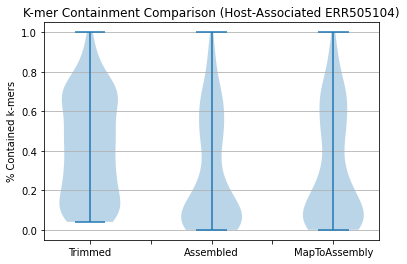

<Figure size 864x576 with 0 Axes>

In [50]:
fig, axes = plt.subplots()
axes.violinplot(dataset = [df.trim_cont, df.assem_cont, df.mapassem_cont])

plt.figure(figsize=(12, 8))
axes.set_title('K-mer Containment Comparison (Host-Associated ERR505104)')
axes.yaxis.grid(True)
axes.set_ylabel('% Contained k-mers')
axes.set_xticklabels([])
labels = ['', 'Trimmed', '', 'Assembled', '', 'MapToAssembly']
axes.set_xticklabels(labels)
